# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [ ]:
!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

In [1]:
import os
import cv2

### 1.2 Annotate Images with LabelMe

In [ ]:
!labelme

# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [2]:
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Load Image into TF Data Pipeline

In [9]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [10]:
images.as_numpy_iterator().next()

b'data\\images\\WIN_20220624_11_53_01_Pro.jpg'

In [11]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [12]:
images = images.map(load_image)

In [13]:
images.as_numpy_iterator().next()

array([[[176, 179, 184],
        [176, 179, 184],
        [177, 180, 185],
        ...,
        [201, 206, 212],
        [201, 206, 212],
        [200, 205, 211]],

       [[176, 179, 184],
        [176, 179, 184],
        [177, 180, 185],
        ...,
        [201, 206, 212],
        [200, 205, 211],
        [200, 205, 211]],

       [[176, 179, 184],
        [177, 180, 185],
        [178, 181, 186],
        ...,
        [201, 206, 212],
        [200, 205, 211],
        [200, 205, 211]],

       ...,

       [[115, 115, 115],
        [115, 115, 115],
        [115, 115, 115],
        ...,
        [135, 134, 132],
        [135, 134, 130],
        [134, 133, 129]],

       [[114, 114, 114],
        [114, 114, 114],
        [114, 114, 114],
        ...,
        [134, 133, 131],
        [134, 133, 129],
        [133, 132, 128]],

       [[114, 114, 114],
        [114, 114, 114],
        [114, 114, 114],
        ...,
        [134, 133, 131],
        [133, 132, 128],
        [133, 132, 128]]

In [14]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

### 2.3 View Raw Images with Matplotlib

In [15]:
image_generator = images.batch(4).as_numpy_iterator()

In [16]:
plot_images = image_generator.next()

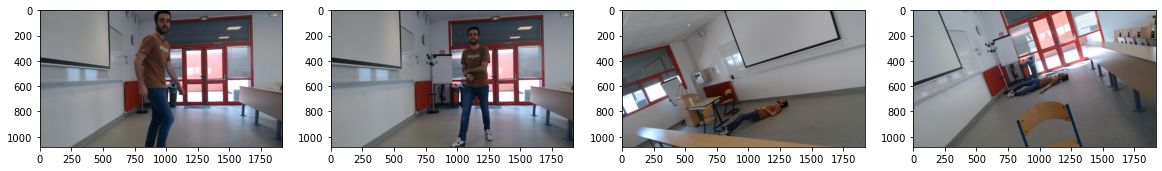

In [17]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [ ]:
# Move images in the file images in train, test and split file in data file

### 3.2 Move the Matching Labels

In [44]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [7]:
import albumentations as alb

In [8]:
augmentor = alb.Compose([alb.RandomCrop(width=1070, height=1070), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [ ]:
# Take care to change the name of the image that you want to see

In [9]:
img = cv2.imread(os.path.join('data','train', 'images','WIN_20220624_11_43_53_Pro.jpg'))

In [10]:
with open(os.path.join('data', 'train', 'labels', 'WIN_20220624_11_43_53_Pro.json'), 'r') as f:
    label = json.load(f)

In [11]:
label['shapes'][0]['points']

[[916.951219512195, 139.73170731707316], [1343.780487804878, 1069.0]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [12]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [13]:
coords

[916.951219512195, 139.73170731707316, 1343.780487804878, 1069.0]

In [14]:
coords = list(np.divide(coords, [1920,1080,1920,1080]))

In [15]:
coords

[0.4775787601626016,
 0.12938121047877144,
 0.6998856707317073,
 0.9898148148148148]

### 4.4 Apply Augmentations and View Results

In [16]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=[['fall', 'noFall']])

In [17]:
augmented['bboxes']

[(0.43945748803282425,
  0.0009345794392523477,
  0.838363346250285,
  0.8694096193298382)]

In [18]:
augmented['bboxes'][0][2:]

(0.838363346250285, 0.8694096193298382)

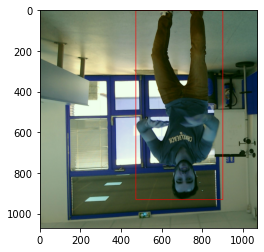

In [19]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [1070,1070]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [1070,1070]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [21]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [1920,1080,1920,1080]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=[['noFall', 'fall']])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = (1 if label['shapes'][0]["label"] == 'noFall' else 2)
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 5.2 Load Augmented Images to Tensorflow Dataset

In [27]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [28]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [29]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [44]:
train_images.as_numpy_iterator().next()

array([[[0.52173203, 0.44330063, 0.45114377],
        [0.5246936 , 0.44626224, 0.4541054 ],
        [0.5109136 , 0.43248227, 0.43640384],
        ...,
        [0.4905229 , 0.3972224 , 0.35964102],
        [0.47467318, 0.39575163, 0.36846405],
        [0.47860128, 0.4       , 0.35606524]],

       [[0.52156866, 0.4392157 , 0.45882353],
        [0.52457106, 0.4461397 , 0.45006126],
        [0.51885206, 0.44042075, 0.44434232],
        ...,
        [0.49248335, 0.4       , 0.35996717],
        [0.49411765, 0.40784314, 0.3647059 ],
        [0.47843137, 0.39215687, 0.34901962]],

       [[0.52924836, 0.44689542, 0.4665033 ],
        [0.52156866, 0.4392157 , 0.45882353],
        [0.527131  , 0.44869962, 0.45654276],
        ...,
        [0.49200028, 0.39543167, 0.35703298],
        [0.49411765, 0.3882353 , 0.35457516],
        [0.490162  , 0.3842796 , 0.3489855 ]],

       ...,

       [[0.42365876, 0.34130582, 0.36091366],
        [0.4305554 , 0.34820247, 0.3678103 ],
        [0.42581046, 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [15]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [30]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [31]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [32]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [49]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.1478   , 0.0009346, 0.547    , 0.8696   ], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [50]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(5520, 5520, 900, 900, 900, 900)

### 7.2 Create Final Datasets (Images/Labels)

In [33]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(6000)
train = train.batch(8)
train = train.prefetch(4)

In [34]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [35]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1300)
val = val.batch(8)
val = val.prefetch(4)

In [54]:
test.as_numpy_iterator().next()[1]

(array([[2],
        [2],
        [1],
        [2],
        [1],
        [2],
        [2],
        [2]], dtype=uint8),
 array([[0.4333 , 0.543  , 0.955  , 0.781  ],
        [0.4102 , 0.2986 , 1.     , 0.999  ],
        [0.     , 0.1672 , 0.02054, 0.6387 ],
        [0.1224 , 0.1376 , 1.     , 0.5474 ],
        [0.0732 , 0.1945 , 0.3616 , 0.949  ],
        [0.08057, 0.5513 , 0.602  , 0.789  ],
        [0.2522 , 0.2146 , 0.7734 , 0.4524 ],
        [0.4329 , 0.3955 , 1.     , 0.8154 ]], dtype=float16))

### 7.3 View Images and Annotations

In [55]:
data_samples = train.as_numpy_iterator()

In [70]:
res = data_samples.next()

In [ ]:
# res = data_samples.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [4]:
vgg = VGG16(include_top=False)

In [5]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [6]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    falltracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return falltracker

### 8.4 Test out Neural Network

In [36]:
falltracker = build_model()

In [37]:
falltracker.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_4[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d_2 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                              

In [38]:
X, y = train.as_numpy_iterator().next()

In [39]:
X.shape

(8, 120, 120, 3)

In [40]:
classes, coords = falltracker.predict(X)

1/1 [==============================] - 1s 1s/step


In [41]:
classes, coords

(array([[0.433917  ],
        [0.40327397],
        [0.41787788],
        [0.39566162],
        [0.3872212 ],
        [0.40426368],
        [0.27996978],
        [0.34497052]], dtype=float32),
 array([[0.7040001 , 0.4728242 , 0.68290967, 0.4403587 ],
        [0.6734857 , 0.5263906 , 0.6977397 , 0.44575685],
        [0.7457621 , 0.5118324 , 0.68056256, 0.42426142],
        [0.6317932 , 0.53075004, 0.6886429 , 0.43038836],
        [0.653362  , 0.5551789 , 0.67098844, 0.43294597],
        [0.67019373, 0.5942273 , 0.68552923, 0.4283636 ],
        [0.62885815, 0.45198125, 0.69283044, 0.46959913],
        [0.77464205, 0.48921868, 0.7005425 , 0.46162984]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [42]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [43]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [44]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [45]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [46]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.087024>

In [47]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=1.1180725>

In [48]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.087024>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [49]:
class FallTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [50]:
model = FallTracker(falltracker)

In [51]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [52]:
logdir='logs'

In [53]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [54]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/40
690/690 [==============================] - 768s 1s/step - total_loss: -2.5958 - class_loss: -6.2142 - regress_loss: 0.5114 - val_total_loss: -3.7777 - val_class_loss: -7.6243 - val_regress_loss: 0.0345
Epoch 2/40
690/690 [==============================] - 801s 1s/step - total_loss: -3.0313 - class_loss: -6.4176 - regress_loss: 0.1775 - val_total_loss: -3.7227 - val_class_loss: -7.6246 - val_regress_loss: 0.0895
Epoch 3/40
690/690 [==============================] - 815s 1s/step - total_loss: -3.0711 - class_loss: -6.4231 - regress_loss: 0.1404 - val_total_loss: -3.7205 - val_class_loss: -7.6042 - val_regress_loss: 0.0816
Epoch 4/40
690/690 [==============================] - 838s 1s/step - total_loss: -3.1274 - class_loss: -6.4354 - regress_loss: 0.0903 - val_total_loss: -3.7228 - val_class_loss: -7.6246 - val_regress_loss: 0.0895
Epoch 5/40
690/690 [==============================] - 968s 1s/step - total_loss: -3.1379 - class_loss: -6.4309 - regress_loss: 0.0775 - val_total_lo

### 10.3 Plot Performance

In [55]:
hist.history

{'total_loss': [-2.7950358390808105,
  -1.8198466300964355,
  -2.773791551589966,
  -1.9134681224822998,
  -0.9098328351974487,
  -3.7910690307617188,
  -1.8945640325546265,
  -1.8830920457839966,
  -2.846750497817993,
  -1.8959704637527466,
  0.6677072048187256,
  -2.853306531906128,
  -2.8535139560699463,
  -4.760315895080566,
  -3.8008713722229004,
  -2.8531651496887207,
  -4.760981559753418,
  -2.8538947105407715,
  -4.760324001312256,
  -3.809048891067505,
  -4.762699127197266,
  -4.761880874633789,
  -2.8553926944732666,
  -2.8582286834716797,
  -3.8111014366149902,
  -3.811772584915161,
  -3.810863494873047,
  -2.8577332496643066,
  -1.9044886827468872,
  -0.9522520303726196,
  -3.8059167861938477,
  -3.809901475906372,
  -2.857192277908325,
  -3.809453010559082,
  -4.763723850250244,
  -2.8580615520477295,
  -3.8106260299682617,
  -2.8588523864746094,
  -2.8569865226745605,
  -0.9519225358963013],
 'class_loss': [-5.718463897705078,
  -3.8123083114624023,
  -5.717829704284668,


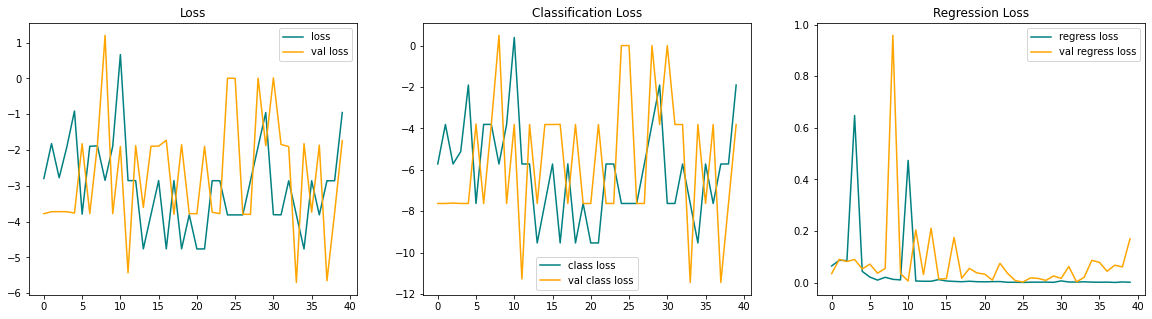

In [56]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [57]:
test_data = test.as_numpy_iterator()

In [58]:
test_sample = test_data.next()

In [59]:
yhat = falltracker.predict(test_sample[0])

1/1 [==============================] - 0s 206ms/step


1/1 [==============================] - 0s 173ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1.]
[1.]
[1.]
[1.]


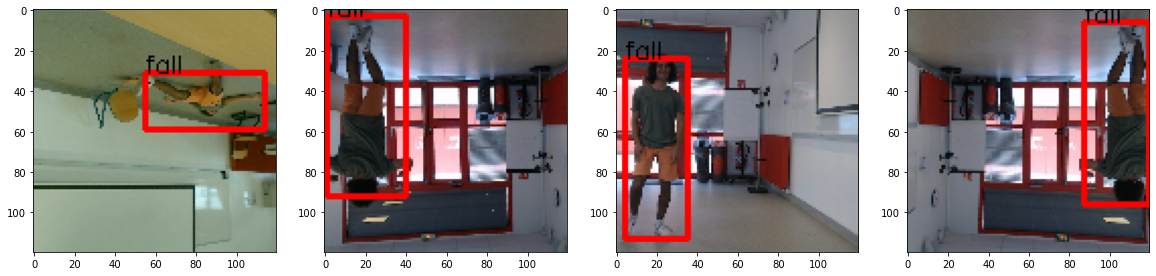

In [66]:
#test_sample = test_data.next()
#yhat = falltracker.predict(test_sample[0])
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx] #(255,0,0)
    sample_coords = yhat[1][idx]
    print(yhat[0][idx])
    if yhat[0][idx] < 1 and yhat[0][idx] > 0.5:
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (0,255,0), 2)
        cv2.putText(sample_image, 'noFall', (tuple(np.multiply(sample_coords[:2], [120,120]).astype(int))), cv2.FONT_HERSHEY_SIMPLEX, 0.4, 0)
    if yhat[0][idx] == 1:
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
        cv2.putText(sample_image, 'fall', (tuple(np.multiply(sample_coords[:2], [120,120]).astype(int))), cv2.FONT_HERSHEY_SIMPLEX, 0.4, 0)
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [16]:
from tensorflow.keras.models import load_model

In [76]:
falltracker.save('new_falltracker.h5')

In [77]:
falltracker = load_model('new_falltracker.h5')

### 11.3 Real Time Detection

In [12]:
import cv2
import tensorflow as tf
import numpy as np

In [13]:
from tensorflow.keras.models import load_model
falltracker = load_model('new_ falltracker.h5')

In [15]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = falltracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    print(yhat[0][0])
    if yhat[0][0] < 1 and yhat[0][0] > 0.5:
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (0,255,0), 2)   
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [100,0])), 
                            (0,255, 0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'noFall', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    if yhat[0][0] == 1:
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (0,0,255), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (0,0,255), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'fall', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('Fall Detection', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 62ms/step
[0.9999963]
1/1 [==============================] - 0s 73ms/step
[0.99999726]
1/1 [==============================] - 0s 60ms/step
[0.9999969]
1/1 [==============================] - 0s 61ms/step
[0.99999195]
1/1 [==============================] - 0s 59ms/step
[0.9999921]
1/1 [==============================] - 0s 58ms/step
[0.9999745]
1/1 [==============================] - 0s 63ms/step
[0.99996555]
1/1 [==============================] - 0s 67ms/step
[0.99997944]
1/1 [==============================] - 0s 61ms/step
[0.9999681]
1/1 [==============================] - 0s 59ms/step
[0.99996847]
1/1 [==============================] - 0s 57ms/step
[0.9999798]
1/1 [==============================] - 0s 56ms/step
[0.9999908]
1/1 [==============================] - 0s 62ms/step
[0.99999064]
1/1 [==============================] - 0s 58ms/step
[0.99998975]
1/1 [==============================] - 0s 57ms/step
[0.9999909]
1/1 [============================

1/1 [==============================] - 0s 57ms/step
[1.]
1/1 [==============================] - 0s 56ms/step
[1.]
1/1 [==============================] - 0s 58ms/step
[1.]
1/1 [==============================] - 0s 57ms/step
[0.99999845]
1/1 [==============================] - 0s 57ms/step
[0.9999998]
1/1 [==============================] - 0s 56ms/step
[0.99999547]
1/1 [==============================] - 0s 61ms/step
[0.9999899]
1/1 [==============================] - 0s 56ms/step
[0.99999845]
1/1 [==============================] - 0s 55ms/step
[0.9999986]
1/1 [==============================] - 0s 55ms/step
[0.9999994]
1/1 [==============================] - 0s 56ms/step
[0.999999]
1/1 [==============================] - 0s 58ms/step
[0.9999999]
1/1 [==============================] - 0s 58ms/step
[1.]
1/1 [==============================] - 0s 56ms/step
[1.]
1/1 [==============================] - 0s 58ms/step
[1.]
1/1 [==============================] - 0s 61ms/step
[1.]
1/1 [==================

1/1 [==============================] - 0s 59ms/step
[1.]
1/1 [==============================] - 0s 59ms/step
[1.]
1/1 [==============================] - 0s 57ms/step
[1.]
1/1 [==============================] - 0s 56ms/step
[1.]
1/1 [==============================] - 0s 59ms/step
[1.]
1/1 [==============================] - 0s 57ms/step
[1.]
1/1 [==============================] - 0s 56ms/step
[1.]
1/1 [==============================] - 0s 57ms/step
[1.]
1/1 [==============================] - 0s 60ms/step
[1.]
1/1 [==============================] - 0s 61ms/step
[1.]
1/1 [==============================] - 0s 60ms/step
[0.999996]
1/1 [==============================] - 0s 56ms/step
[0.99999]
1/1 [==============================] - 0s 57ms/step
[0.9999997]
1/1 [==============================] - 0s 57ms/step
[0.9999998]
1/1 [==============================] - 0s 58ms/step
[0.99999994]
1/1 [==============================] - 0s 56ms/step
[0.9999997]
1/1 [==============================] - 0s 55ms/s

[1.]
1/1 [==============================] - 0s 58ms/step
[1.]
1/1 [==============================] - 0s 60ms/step
[1.]
1/1 [==============================] - 0s 60ms/step
[1.]
1/1 [==============================] - 0s 56ms/step
[1.]
1/1 [==============================] - 0s 57ms/step
[1.]
1/1 [==============================] - 0s 58ms/step
[1.]
1/1 [==============================] - 0s 57ms/step
[1.]
1/1 [==============================] - 0s 59ms/step
[1.]
1/1 [==============================] - 0s 59ms/step
[1.]
1/1 [==============================] - 0s 58ms/step
[1.]
1/1 [==============================] - 0s 60ms/step
[1.]
1/1 [==============================] - 0s 57ms/step
[1.]
1/1 [==============================] - 0s 59ms/step
[1.]
1/1 [==============================] - 0s 59ms/step
[1.]
1/1 [==============================] - 0s 58ms/step
[1.]
1/1 [==============================] - 0s 59ms/step
[1.]
1/1 [==============================] - 0s 59ms/step
[1.]
1/1 [=====================